# Acoustic inhomogeneous model

## Theory and derivations

The general wave equation is derived from the equation of motion

\begin{equation} \label{eq:eq_of_motion}
\frac{\partial T}{\partial x} = \rho \frac{\partial^2 u}{\partial t^2}, 
\end{equation}

where $T, x, u$ and $t$ denote the stress, position, displacement and time. Consider Hooke's law

$T = c \frac{\partial u }{\partial x}$

where $c$ is the stiffness coefficient. If we substitute this equation into equation \eqref{eq_of_motion}(above) and assume $c$ to vary with $x$, we obtain 

\begin{equation} \label{eq:hooke_substituted}
\rho \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x}\left( c \frac{\partial u }{\partial x}  \right)
\end{equation}

where the comma followed by a $x$ denotes If we assume the modes to be stationary, we can substitute $u(x,t) = u(x) e^{i \omega t}$ into equation \ref{eq:hooke_substituted} and divide by $e^{i \omega t}$ to obtain:

\begin{equation} \label{eq:inhom_ac_stat}
- \rho \omega^2 u = \frac{\partial}{\partial x}\left( c \frac{\partial u }{\partial x}  \right)
\end{equation}

Which we can solve numerically by writing it as an eigenvalue problem using the finite difference method. This will result in 

$$
(-\pmb{\rho} \circ I) \omega^2 \mathbf{u} = A \mathbf{u},
$$

where 

$$
-\pmb{\rho} \circ I = -
\begin{bmatrix}
\rho_1 &  & & \\
 & \rho_2 & &0\\
& & \ddots &\\
&0 & & & \rho_{N}
\end{bmatrix}
$$

This is the generalized eigenvalue problem. If only $\rho$ is homogeneous and only $c$ is inhomogeneous, $\pmb{\rho} \circ I$ reduces to $\rho I$ and the problem just becomes

$$
-\rho \omega^2 \mathbf{u} = A \mathbf{u}
$$

Which is a regular eigenvalue problem. If it is the other way around and $c$ is constant, while $\rho$ is inhomogeneous, A just reduces to central difference 1D laplacian which we have studied in the homogeneous acoustic model. 

#### inhomogeneous stiffness

On the right hand side of equation \eqref{eq:inhom_ac_stat} the differential operator operates on both the mechanical displacement and the stiffness coefficient. We need a different finite difference discretization than what we have seen up to now. Preferably this discretization results in a symmetric system matrix, such that we certainly find real eigenfrequencies. Let us now consider this right hand side in general form with coefficient $k$

$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right)_i,
$$

where $x$ denotes the position, $y=y(x)$ is the solution, and $k=k(x)$ is a space dependent coefficient. If we define 

$$
a_i = \frac{k(x_i) + k(x_{i-1})}{2}
$$

We then find that <font color = "red">Have not derived this myself, but will do this<font color = "black">

$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right)_i = \frac{1}{h^2} \left[a_{i} u_{i-1} -(a_{i} + a_{i+1}) u_{i} + a_{i+1} u_{i+1}\right] + \mathcal{O}(h^2)
$$

So the equations near the boundary (i=2, N-1) for 0-dirichlet boundary conditions become:


$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right)_2 = \frac{1}{h^2} \left[ -(a_{2} + a_{3}) u_{2} + a_{3} u_{3}\right] + \mathcal{O}(h^2)
$$

$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right)_{N-1} = \frac{1}{h^2} \left[a_{N-1} u_{N-2} -(a_{N-1} + a_{N}) u_{N-1}\right] + \mathcal{O}(h^2)
$$

And for 0-neumann boundary conditions they become:
$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right)_2 = \frac{1}{h^2} \left[-a_{3} u_{2} + a_{3} u_{3}\right] + \mathcal{O}(h^2)
$$

$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right)_{N-1} = \frac{1}{h^2} \left[a_{N-1} u_{N-2} -(a_{N-1}) u_{N-1}\right] + \mathcal{O}(h^2)
$$






## The numerical method

imports

In [17]:
import numpy as np
import matplotlib.pylab as plt
from time import time
import scipy.linalg as la
import scipy.signal as sig
from time import time

Some material properties are set below

In [18]:
#sapphire
rho_Sap = 3980 #kg/m^3
c_Sap = 345e9 #pa

#AlN
rho_AlN = 3260
c_AlN = 330e9

Some other global parameters which we will always use

In [19]:
#Number of points 
N = 100

#Range 
x0 = 0 
x1 = N-1

#create x array
x = np.linspace(x0,x1,N)

#switch point
xs = (x1-x0)/2
switch_i = np.where(x>xs)[0][0]

Below you see the functions for both the homogeneous acoustic and the inhomogeneous acoustic model

In [20]:
def acoustic_homogeneous(x, rho, c, BC1, BC2):
    #Determine the spacing
    dx = x[1] - x[0]

    #n.o. points
    N = len(x)
    
    #Make the matrix using the central finite difference approximation
    #inbetween we want the -1, 0, -1 on each row to get the central derivatives
    M = -np.eye(N-2,k=-1) + 2*np.eye(N-2) - np.eye(N-2,k=1)
    
    #Apply neuman B.C. if stated
    if BC1 == "neumann": 
        M[0,0] = 1
    if BC2 == "neumann":
        M[-1,-1] = 1

    #Scale with the right constant c/rho and divide by the discretization 
    M*= c/rho/dx**2

    #finding the frequencies and modes
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    
    if BC1 == "dirichlet":
        eigenvectors = np.concatenate(([np.zeros(len(eigenvectors))], eigenvectors))
    else: 
        eigenvectors = np.concatenate(([eigenvectors[0]], eigenvectors))
    if BC2 == "dirichlet":
        eigenvectors = np.concatenate((eigenvectors, [np.zeros(len(eigenvectors)-1)]))
    else: 
        eigenvectors = np.concatenate((eigenvectors, [eigenvectors[-1]]))
        

    #find the eigenvrequencies
    frequency = np.sqrt(np.abs(eigenvalues))
    
    return frequency.real, eigenvectors.real

In [21]:
def acoustic_inhomogeneous(x, rho, c, BC1, BC2):
    BC_check = ["neumann", "dirichlet"]
    assert ((BC1 in BC_check) and (BC2 in BC_check)), "both boundary conditions must be 'neumann' or 'dirichlet'"
    
    #Determine the spacing
    dx = x[1] - x[0]
    
    #compute the weight coefficient for this FD method
    a = (c[1:] + c[:-1]) / 2
    
    # Create the system matrix
    main = - a[:-1] - a[1:]
    off = a[1:-1]

    # If dirichlet, no action is required, if neumann do this
    if BC1 == "neumann": 
        #Apply neuman B.C.
        main[0] = -a[1]
    if BC2 == "neumann":
        main[-1] = -a[-2]

    #make the LHS matrix
    M = 1 / (dx**2) * (np.diag(main, k=0) + np.diag(off,k=1) + np.diag(off,k=-1))

    #make the matrix with rho on diagonal
    RHO = np.diag(rho[1:-1],k=0)
    
    #find the values and vectors from the generalized eigenvalue solver
    eigvals, eigvecs = la.eig(a = M, b=-RHO)

    #sort them
    vecs_sort = eigvecs[:,np.argsort(eigvals)]
    freq_sort = np.sort(np.sqrt(eigvals))
    
    
    if BC1 == "dirichlet":
        vecs_sort = np.concatenate(([np.zeros(len(vecs_sort))], vecs_sort))
    else: 
        vecs_sort = np.concatenate(([vecs_sort[0]], vecs_sort))
    if BC2 == "dirichlet":
        vecs_sort = np.concatenate((vecs_sort, [np.zeros(len(vecs_sort)-1)]))
    else: 
        vecs_sort = np.concatenate((vecs_sort, [vecs_sort[-1]]))
    
    return freq_sort.real, vecs_sort.real

After a time analysis (which I deleted) I found that 

$$
\text{runtime} = 1.6468 10^{-10} N^{3.55}
$$

## Results

1. Comparison to the numerical method (no plots in report) <br/>
2. Inhomogeneous density
    * First show the dispersion relation
        * Say that we discussed the curving before. We are getting numerical errors because the frequency is to rapid for the grid spacing. 
        * Can show an example of (a few) modes where we show that it is going wrong.
        * Now this happens earlier in the dispersion, because we have two different wave-vectors, of which one is higher.
        * If we want to have a good physical interpretation, we should limit ourselves to modes below 70 or so. Here we can get the wavelength represented in both sides. 
    * Then show mode 15
        * We have two regions with same frequency but different wavelengths due to different densities. The combination of the boundary conditions at the outside and that the solution must be continuous and have a continuous derivative, gives the different amplitudes
    * Then show index number vs amplitude
        * This should oscillate
        * We could compare it to the analytical solution
            * Doesn't matter that much to Gary

3. Inhomogeneous stifness
    * Show mode 15 again
        * We see a kink
        * Compute the derivative numerically again. We indeed see that there is a discontinuity
            * Lead discussion back to the relevant formula
        * However, if we compute c * the derivative, it becomes continuous.
    * Same analysis of the peak to peak amplitude


### Comparison of the inhomogeneous numerical method to the homogeneous method

Apply the numerical method which was coded to solve the inhomogeneous problem, to solve to homogeneous problem as a benchmark.

In [22]:
#Making homogeneous coefficients to compare the general model with the specific model
rho = np.ones(N) 
c = np.ones(N) 

In [23]:
#solve both
freqs_hom, vecs_hom = acoustic_homogeneous(x, rho[0], c[0], "dirichlet", "dirichlet")
freqs, vecs = acoustic_inhomogeneous(x,rho,c,"dirichlet", "dirichlet")

/Users/samkatiraee-far/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


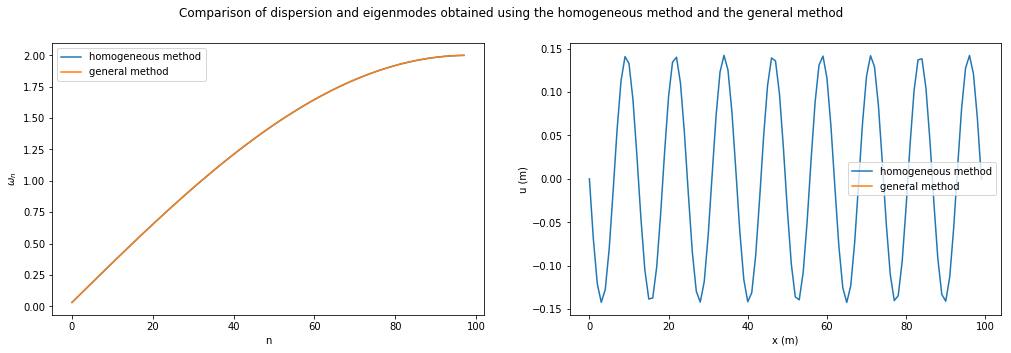

In [24]:
n = np.arange(0,N-2)

#plot dispersion
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.suptitle("Comparison of dispersion and eigenmodes obtained using the homogeneous method and the general method")
plt.plot(n, freqs_hom.real, label = "homogeneous method")
plt.plot(n, freqs.real, label = "general method")
plt.xlabel("n")
plt.ylabel("$\omega_n$")
plt.legend()

#plot mode
mode_index = 15
plt.subplot(122)
plt.plot(x, vecs[:,mode_index].real, label = "homogeneous method") 
#what I did below does not work, i divide by 0
plt.plot(x, vecs[:,mode_index].real[0] * vecs_hom[:,mode_index].real /vecs_hom[:,mode_index].real[0] , label = "general method")
plt.xlabel("x (m)")
plt.ylabel("u (m)")
plt.legend()
plt.show()

The numerical model coded to solve the inhomgeneous acoustic problem uses a generalized eigenvalue solver. This method overlaps with the method used to solve the homogeneous eigenvalue problem which was previously studied.

### Inhomogeneous density

#### Numerical failure at high modes

We now study the acoustic model which consists of two regions with a different density. See the plot below which shows the dispersion relation and a specific mode

In [25]:
#coefficients
rho = np.ones(N) 
c = np.ones(N) 
rho[switch_i:] = 4

#impedances
Z_L = np.sqrt(rho[0]*c[0])
Z_R = np.sqrt(rho[-1]*c[-1])

In [26]:
#compute the case
freq_sort, vecs_sort = acoustic_inhomogeneous(x, rho, c, "neumann", "neumann")

Let's look at the dispersion relation

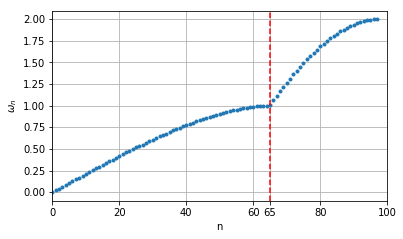

In [27]:
#frequencies
plt.figure(figsize=(6,3.5))
plt.plot(n, freq_sort.real, '.')
plt.axvline(65, c = 'red', ls = '--')
plt.xlabel("n")
plt.ylabel("$\omega_n$")
plt.xticks(list(plt.xticks()[0]) + [65])
plt.grid()
plt.xlim(0,100)
plt.savefig("inhom_density_dispersion_1.pdf")
plt.show()

Above the numerical frequency is plotted against the mode number. The figure shows a similar deviation from the physical linear dispersion as in the acoustic case. Here however, the numerical method fails for smaller $n$. This is due to the fact that in one of the regions we have a shorter wavelength, and hence we need more points to capture the oscillations. At $n = 600$ we see a kink in the dispersion relation. At this point the numerical method completely fails to capture any oscillatios in the region with the shorter wavelength. <font color = "red">why does this increase the slope of the dispersion?<font color = "black"> In the figure below we show a few modes to visualize what was explained above.


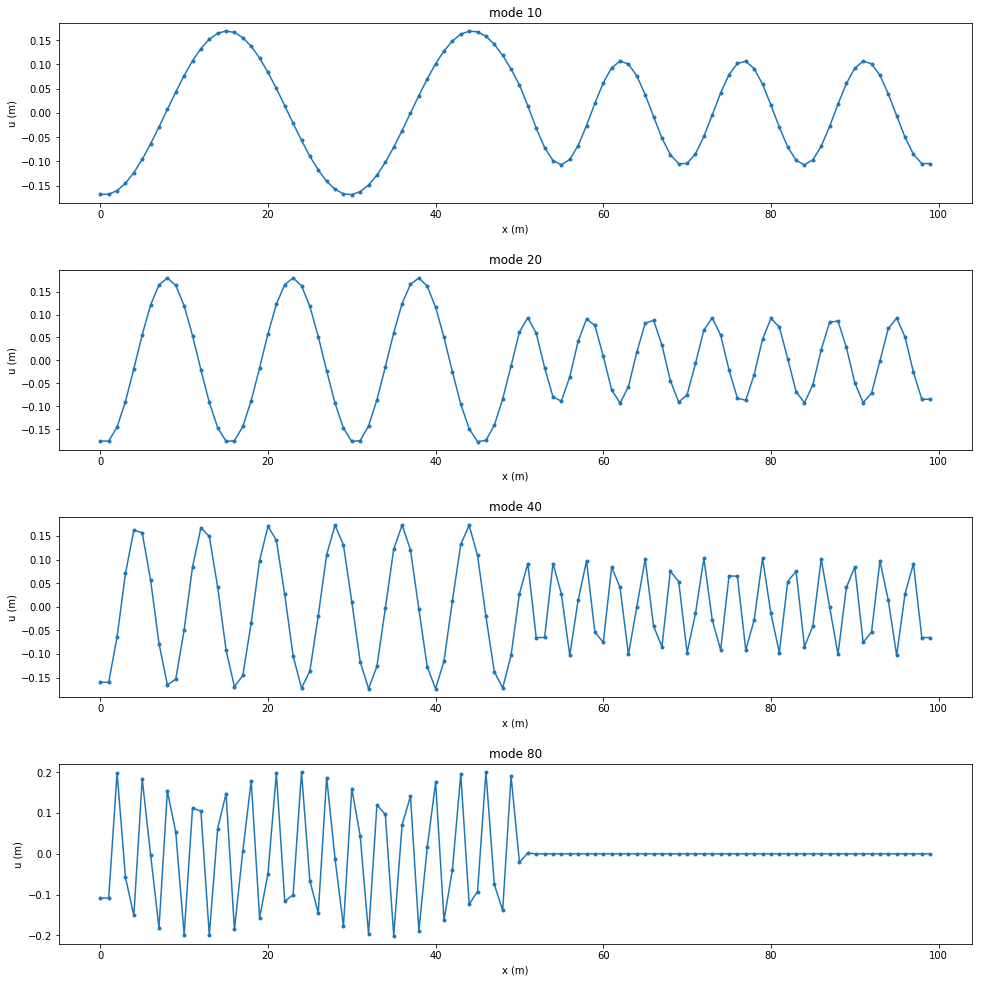

In [28]:
#make subplots with frequencies and modes
mode_indices = [10,20,40,80]

fig, axs = plt.subplots(len(mode_indices),1)
fig.set_figheight(14)
fig.set_figwidth(14)

mode_index = 660

for i in range(len(axs)):
    #modes
    axs[i].plot(x, vecs_sort[:,mode_indices[i]], ls = "-", marker = ".")
    axs[i].set_xlabel("x (m)")
    axs[i].set_ylabel("u (m)")
    axs[i].set_title("mode %d" % mode_indices[i])
plt.tight_layout(pad = 2)
plt.savefig("inhom_density_ex_problems.pdf")
plt.show()

Hence, to be able to give a physical description in the context of the problem, we limit ourselves to modes below 80.

#### Analysis of a mode
Let us study a specific mode. 

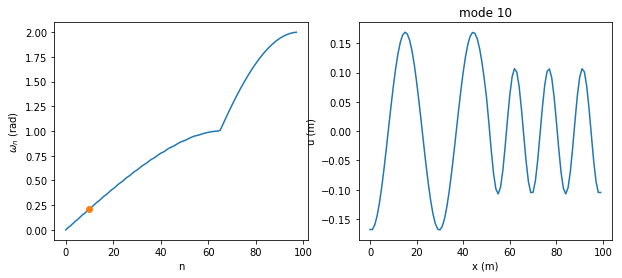

In [29]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)

mode_index = 10

max_mode = 80
axs[0].plot(n, freq_sort.real)
axs[0].set_xlabel("n")
axs[0].set_ylabel("$\omega_n$ (rad)")
axs[0].plot(mode_index, freq_sort.real[mode_index], 'o')

#modes
axs[1].plot(x, vecs_sort[:,mode_index])
axs[1].set_xlabel("x (m)")
axs[1].set_ylabel("u (m)")
axs[1].set_title("mode %d" % mode_index)
plt.savefig("inhom_density_specific_mode.pdf")
plt.show()

Here we see the mode corresponding to $n=15$. We see that the two regions have different wavelength. This is due to the fact that the sound velocity differs in the two regions, while the temporal frequency is constant. Since

$$
v = \lambda f = \lambda \frac{\omega}{2 \pi} \rightarrow \lambda = \frac{2\pi v }{\omega} 
$$

and using the relation between the velocity and density $v = \sqrt{\frac{c}{\rho}}$, we find:

$$ \label{eq:lambda_prop_rho}
\lambda = \frac{2 \pi}{\omega}\sqrt{\frac{c}{\rho}}.
$$

Hence the wavelength is shorter in the high density region. The wavelength was calculated numerically below

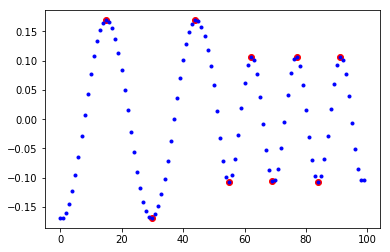

wavelength for the left side:
the wavelenth on the left side = 30.00000000

wavelength for the right side:
the wavelenth on the right side = 14.00000000


In [30]:
#compute the wavelength 
#extract the mode
specific_mode = vecs_sort[:,10]

#find the peaks and valleys, concatenate them into one array, and then sort them
peak_ind = np.sort(np.concatenate((sig.find_peaks(specific_mode)[0], sig.find_peaks(-specific_mode)[0])))

#make a debug plot
plt.plot(x[peak_ind], specific_mode[peak_ind], "or")
plt.plot(x, specific_mode, 'b.')
plt.show()

#splot the peaks indices array
peak_ind_L = peak_ind[np.where(peak_ind < switch_i)[0]]
peak_ind_R = peak_ind[np.where(peak_ind > switch_i)[0]]


#compute the wavelength on both sides
print("wavelength for the left side:")
if len(peak_ind_L) > 1:
    lamda_L = 2 * (x[peak_ind_L[1]] - x[peak_ind_L[0]])
    print(f"the wavelenth on the left side = {lamda_L:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")
print("")
print("wavelength for the right side:")
if len(peak_ind_R) > 1:
    lamda_R = 2 * (x[peak_ind_R[1]] - x[peak_ind_R[0]])
    print(f"the wavelenth on the right side = {lamda_R:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")
    

We can verify whether the numerically obtained wavelength obide to the relation to the frequency, given in equation \eqref{eq:lambda_prop_rho}:

In [32]:
lamda_ana_L = 2 * np.pi / (freq_sort[mode_index]) * np.sqrt(c[0]/rho[0])
lamda_ana_R = 2 * np.pi / (freq_sort[mode_index]) * np.sqrt(c[-1]/rho[-1])

print(f"wavelength left: {lamda_ana_L:.8f} ")
print(f"wavelength right: {lamda_ana_R:.8f} ")

wavelength left: 29.26660646 
wavelength right: 14.63330323 


We see that the values are close and hence obide by equation \eqref{eq:lambda_prop_rho}.

#### Amplitude Oscillations

Let's plot a few eigenmodes again: 

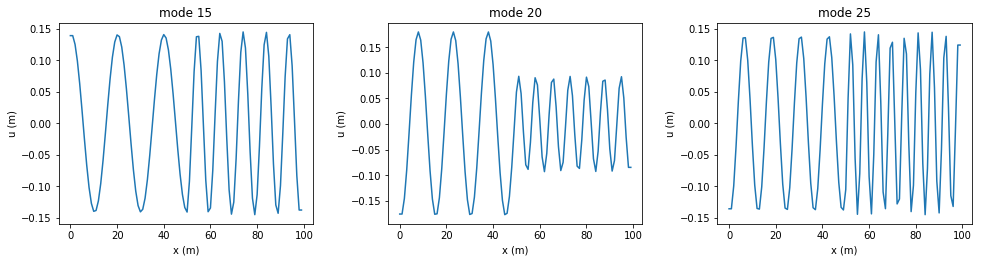

In [33]:
#make subplots with frequencies and modes
mode_indices = [15,20,25]

fig, axs = plt.subplots(1, len(mode_indices))
fig.set_figheight(4)
fig.set_figwidth(14)

mode_index = 660

for i in range(len(axs)):
    #modes
    axs[i].plot(x, vecs_sort[:,mode_indices[i]])
    axs[i].set_xlabel("x (m)")
    axs[i].set_ylabel("u (m)")
    axs[i].set_title("mode %d" % mode_indices[i])
plt.tight_layout(pad = 2)
plt.savefig("inhom_density_vary_amplitude.pdf")
plt.show()


Let us now look at the amplitude for a few different modes. It can be observed that the peak to peak amplitudes in the regions are different for different modes. The amplitude is determined by the boundary conditions on the outside and the boundary conditions on the interface. The boundary condition on the outside is a pure neumann boundary condition, which means that the slope vanishes there. On the interface there is a smooth continuity condition of $u$. To study the behaviour of the peak to peak amplitude of the standing wave, we vary the mode number and plot it. We do this in the code below

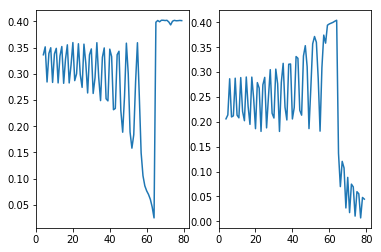

In [17]:
#Split between right and left side
vecs_L = vecs_sort[:switch_i, :max_mode]
vecs_R = vecs_sort[switch_i:, :max_mode]

#Caclulate the amplitude for the modes up to max mode
A_L = 2* np.max(vecs_L, axis = 0)
A_R = 2* np.max(vecs_R, axis = 0)

#plot the amplitudes
plt.subplot(121)
plt.plot(n[4:max_mode], A_L[4:max_mode])
plt.subplot(122)
plt.plot(n[4:max_mode], A_R[4:max_mode])
plt.savefig("inhom_density_ampl_oscillations.pdf")
plt.show()


### Inhomogeneous stiffness

We now perform a similar analysis for varying stiffness. Let us study a specific mode:

In [115]:
#coefficients

N = 1000
x = np.linspace(0,100, N)
rho = np.ones(N) 
c = np.ones(N) 
switch_i = N//2
rho[switch_i:] = rho[0] 
c[switch_i:] = c[0] * 10

#impedances
Z_L = np.sqrt(rho[0]*c[0])
Z_R = np.sqrt(rho[-1]*c[-1])

In [116]:
#compute the case
freq_sort, vecs_sort = acoustic_inhomogeneous(x, rho, c, "neumann", "neumann")

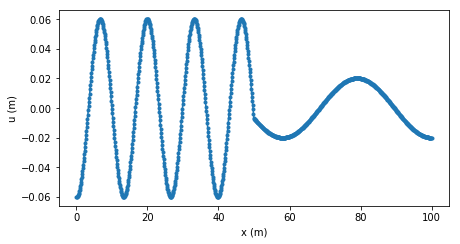

wavelength for the left side:
the wavelenth on the left side = 13.21321321

wavelength for the right side:
the wavelenth on the right side = 41.84184184


In [122]:
#compute the wavelength 
#extract the mode
specific_mode = vecs_sort[:,10]



#find the peaks and valleys, concatenate them into one array, and then sort them
peak_ind = np.sort(np.concatenate((sig.find_peaks(specific_mode)[0], sig.find_peaks(-specific_mode)[0])))

#make a debug plot
plt.figure(figsize = (7,3.6))
#plt.plot(x[peak_ind], specific_mode[peak_ind], "or")
plt.plot(x, specific_mode, marker = ".")
plt.xlabel("x (m)")
plt.ylabel("u (m)")
plt.savefig("inhom_stiffness_mode.pdf")
plt.show()

#splot the peaks indices array
peak_ind_L = peak_ind[np.where(peak_ind < switch_i)[0]]
peak_ind_R = peak_ind[np.where(peak_ind > switch_i)[0]]


#compute the wavelength on both sides
print("wavelength for the left side:")
if len(peak_ind_L) > 1:
    lamda_L = 2 * (x[peak_ind_L[1]] - x[peak_ind_L[0]])
    print(f"the wavelenth on the left side = {lamda_L:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")
print("")
print("wavelength for the right side:")
if len(peak_ind_R) > 1:
    lamda_R = 2 * (x[peak_ind_R[1]] - x[peak_ind_R[0]])
    print(f"the wavelenth on the right side = {lamda_R:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")


The most remarkable thing we notice here is that it seems like there is a discontinuous derivative in the mode at the interface position. Let us verify this by taking the numerical derivative.

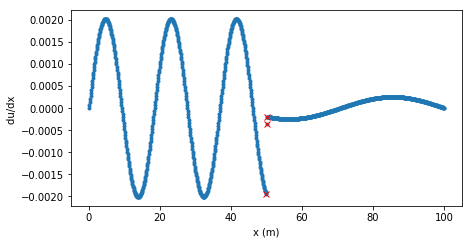

In [124]:
mode_index = 7
mode_diff = np.diff(vecs_sort[:,mode_index])

plt.figure(figsize=(7,3.6))
plt.plot(x[1:],mode_diff, '.')
plt.plot(x[switch_i-1:switch_i+2], mode_diff[switch_i-2:switch_i+1], 'rx')
plt.xlabel("x (m)")
plt.ylabel("du/dx ")
plt.savefig("discont_der.pdf")
plt.show()


We see that the derivative of $u$ is in fact discontiuous. To understand we go back to formula \eqref{eq:inhom_ac_stat}